In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import iminuit as minuit


import scipy

from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chisquare
from iminuit import cost
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2


In [7]:
### read and calibrate data
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


### guassian fit
def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))
def fourpeaks_error(x, par):
    return par[0]*(np.exp((-1.0/2.0)*(((x-par[1])/par[2])**2))) + par[3]*(np.exp((-1.0/2.0)*(((x-par[4])/par[5])**2)))+par[6]*(np.exp((-1.0/2.0)*(((x-par[7])/par[8])**2)))+par[9]*(np.exp((-1.0/2.0)*(((x-par[10])/par[11])**2)))




# f034, no calibration

File: run231_034_output.txt
2 2020-03-25 07:11:55
[' A/q=202/1', ' calibration with At']


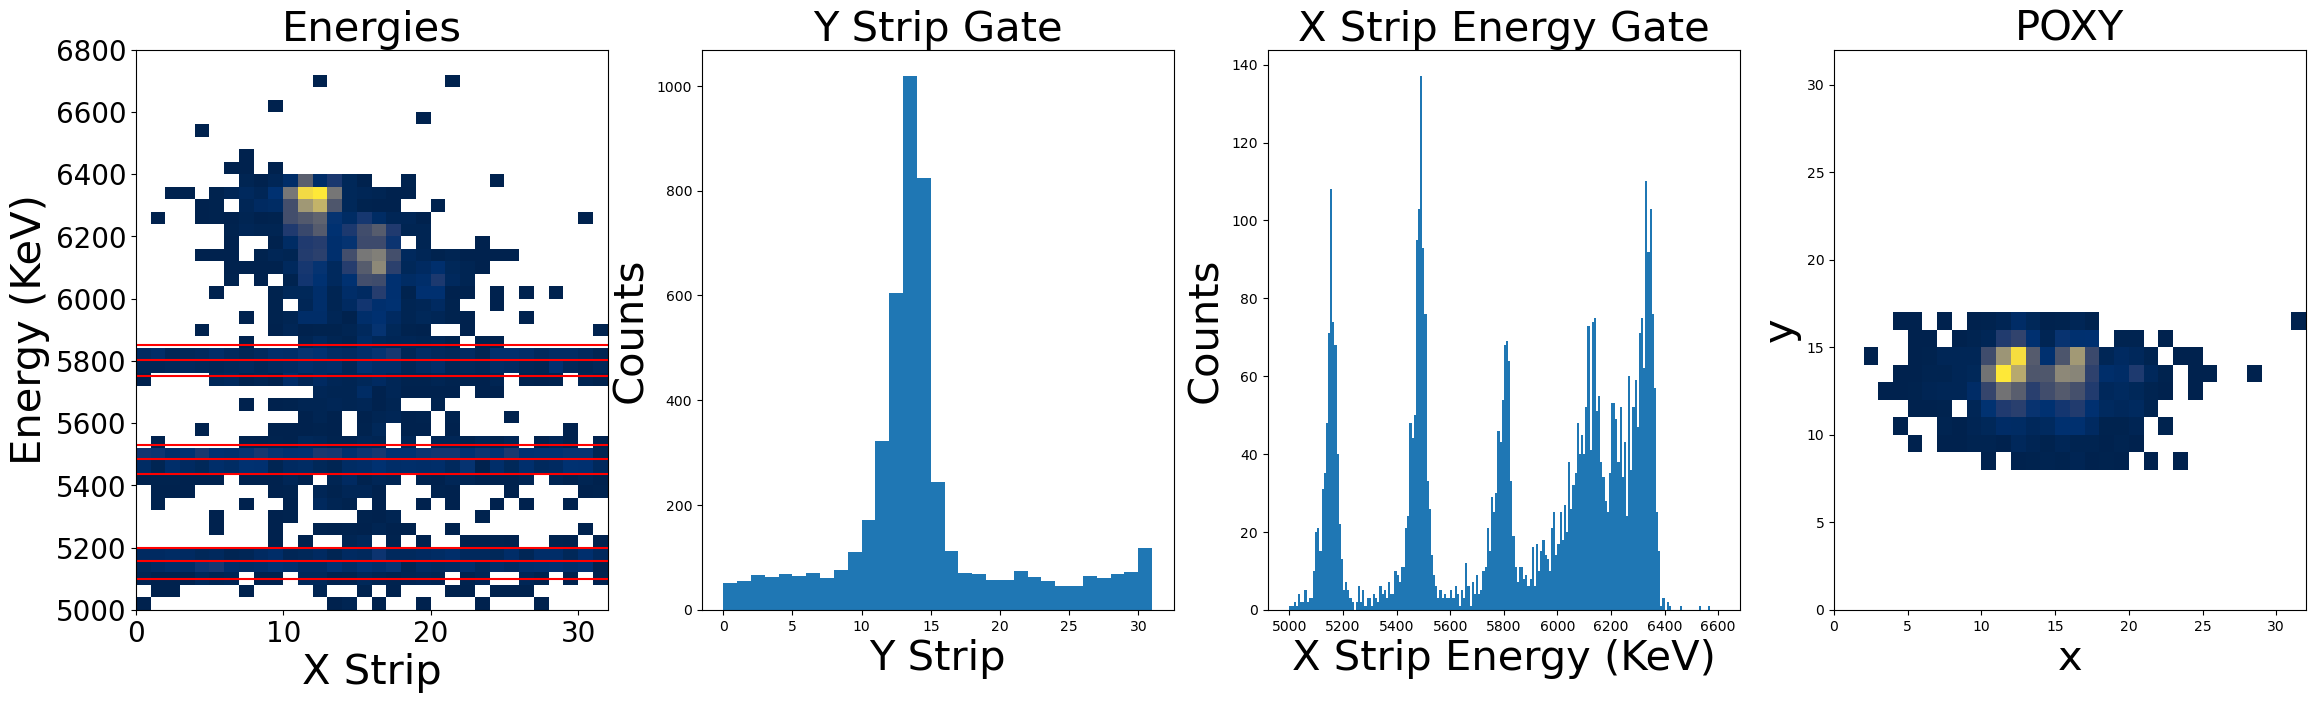

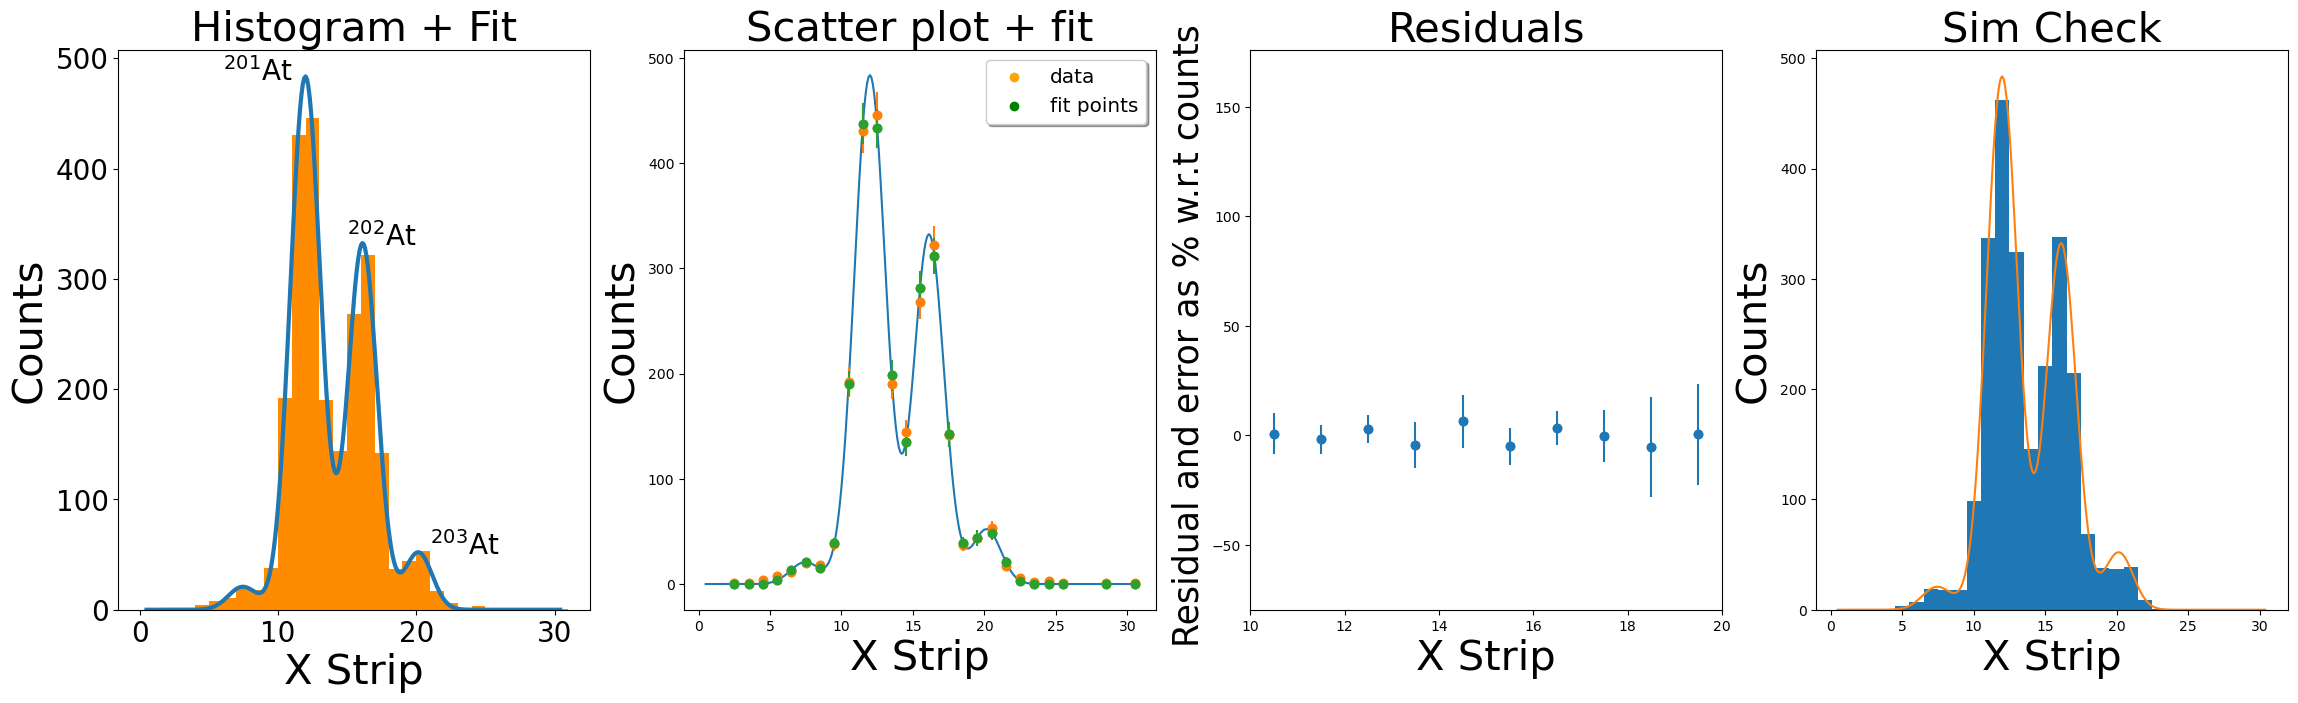

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.49 (chi2/ndof = 1.5)    │              Nfcn = 936              │
│ EDM = 2.1e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [10]:
from scipy.stats import t

cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df_0, t1_0 = readDS('run231_034_output.txt', cal)

### Checking Energies
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,1)
plt.hist2d(df_0['x'], df_0['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")
plt.title("Energies", fontsize = 30)

#### Finding Gates
plt.subplot(2,4,2)
plt.hist(df_0['y'], bins = 31)
plt.xlabel('Y Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Y Strip Gate", fontsize = 30)
plt.subplot(2,4,3)
plt.hist(df_0['xE'], bins = 200, range = (5000,6600))
plt.xlabel('X Strip Energy (KeV)', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("X Strip Energy Gate", fontsize = 30)


### Gating Data and setting up Histograms
gates_0 = df_0[(df_0['y'] >=8) & (df_0['y'] < 17) & (df_0['xE'] > 5900) & (df_0['xE']<6500)]


### POXY
plt.subplot(2,4,4)
plt.hist2d(gates_0['x'], gates_0['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x', fontsize = 30)
plt.ylabel('y', fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_0['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(bins[0], bins[-1], .1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,50,8,1,500,11,1,310,16,1,30,20,1)
m.limits = [(0,None),(7.2,7.8),(0.1,1.04),(0,None), (None,None), (None,None), (0,None ), (0,None), (None, None),(0,None),(None,None),(0, None)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,5)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(6,480, "$^{201}$At", fontsize = 20)
plt.text(15,330, "$^{202}$At", fontsize = 20)
plt.text(21,50, "$^{203}$At", fontsize = 20)

### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [fourpeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(1.5)*np.std(y_b, axis=0)




#### Scatter plot with fit
plt.subplot(2,4,6)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')


### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.subplot(2,4,8)

mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(newcounts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)



hist_sim= plt.hist(x, bins = bins)
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()


print (m.migrad())





# f037

File: run231_037_output.txt
3 2020-03-25 19:28:37
[' scaled to 201/1 for At calibration for 10 mins', ' stopped gas flow', ' changed BGS magnets to Q1=1344 M1=296 M2=465']


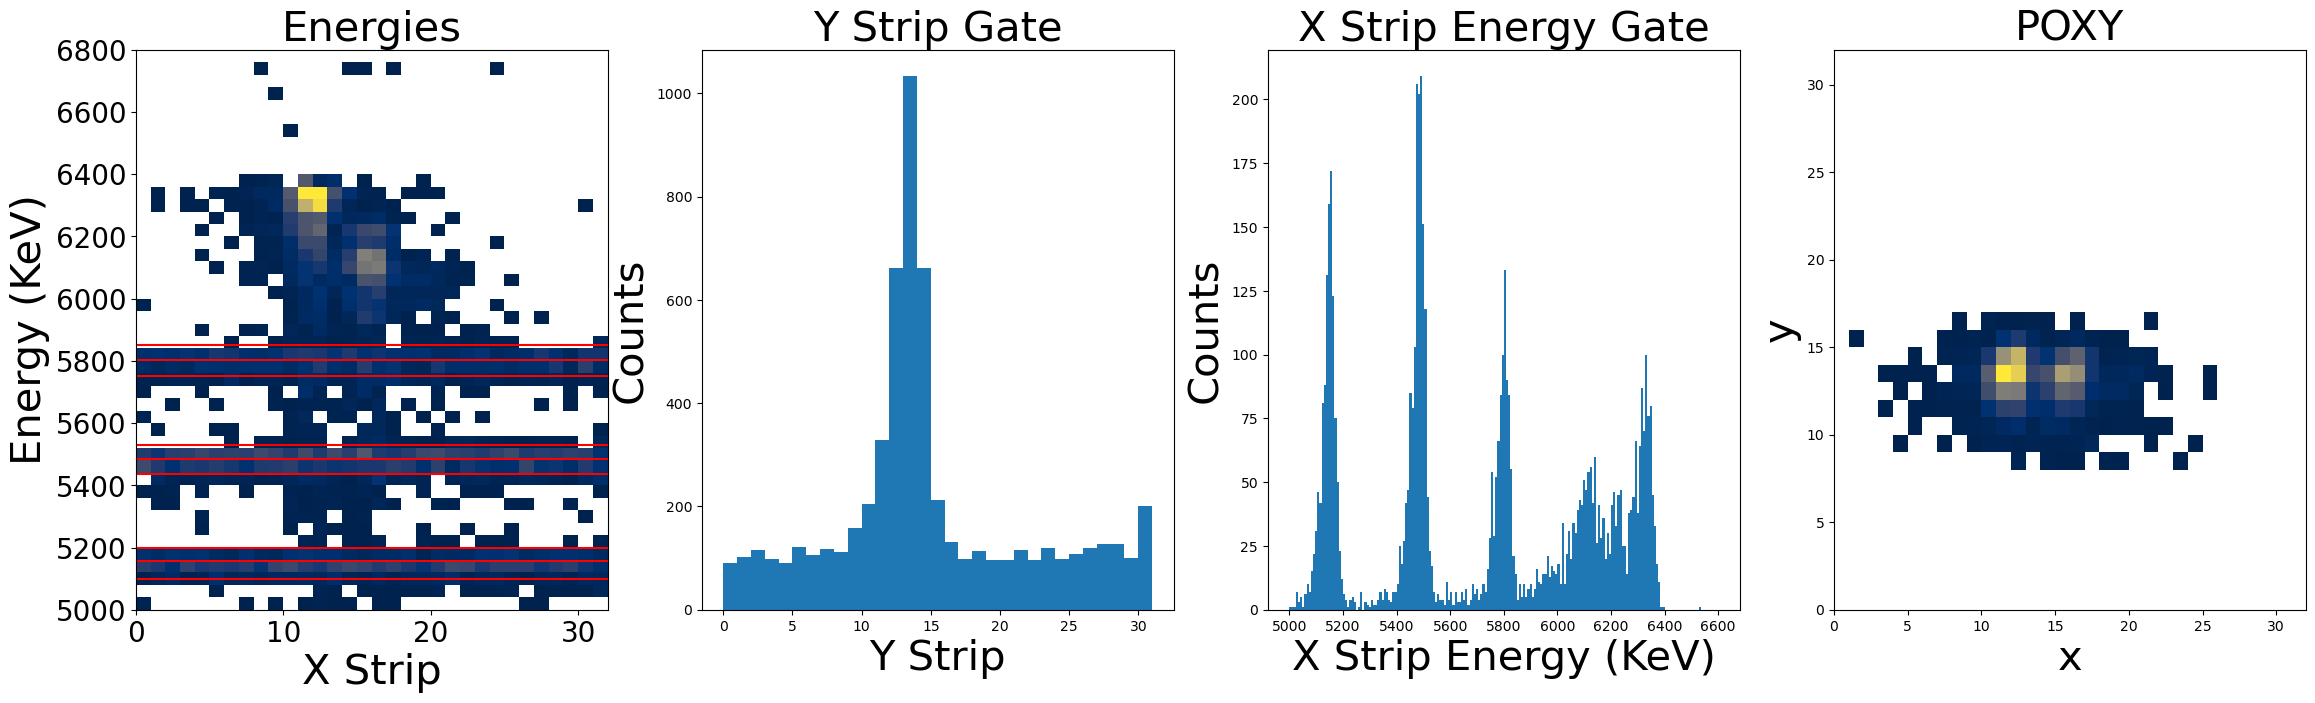

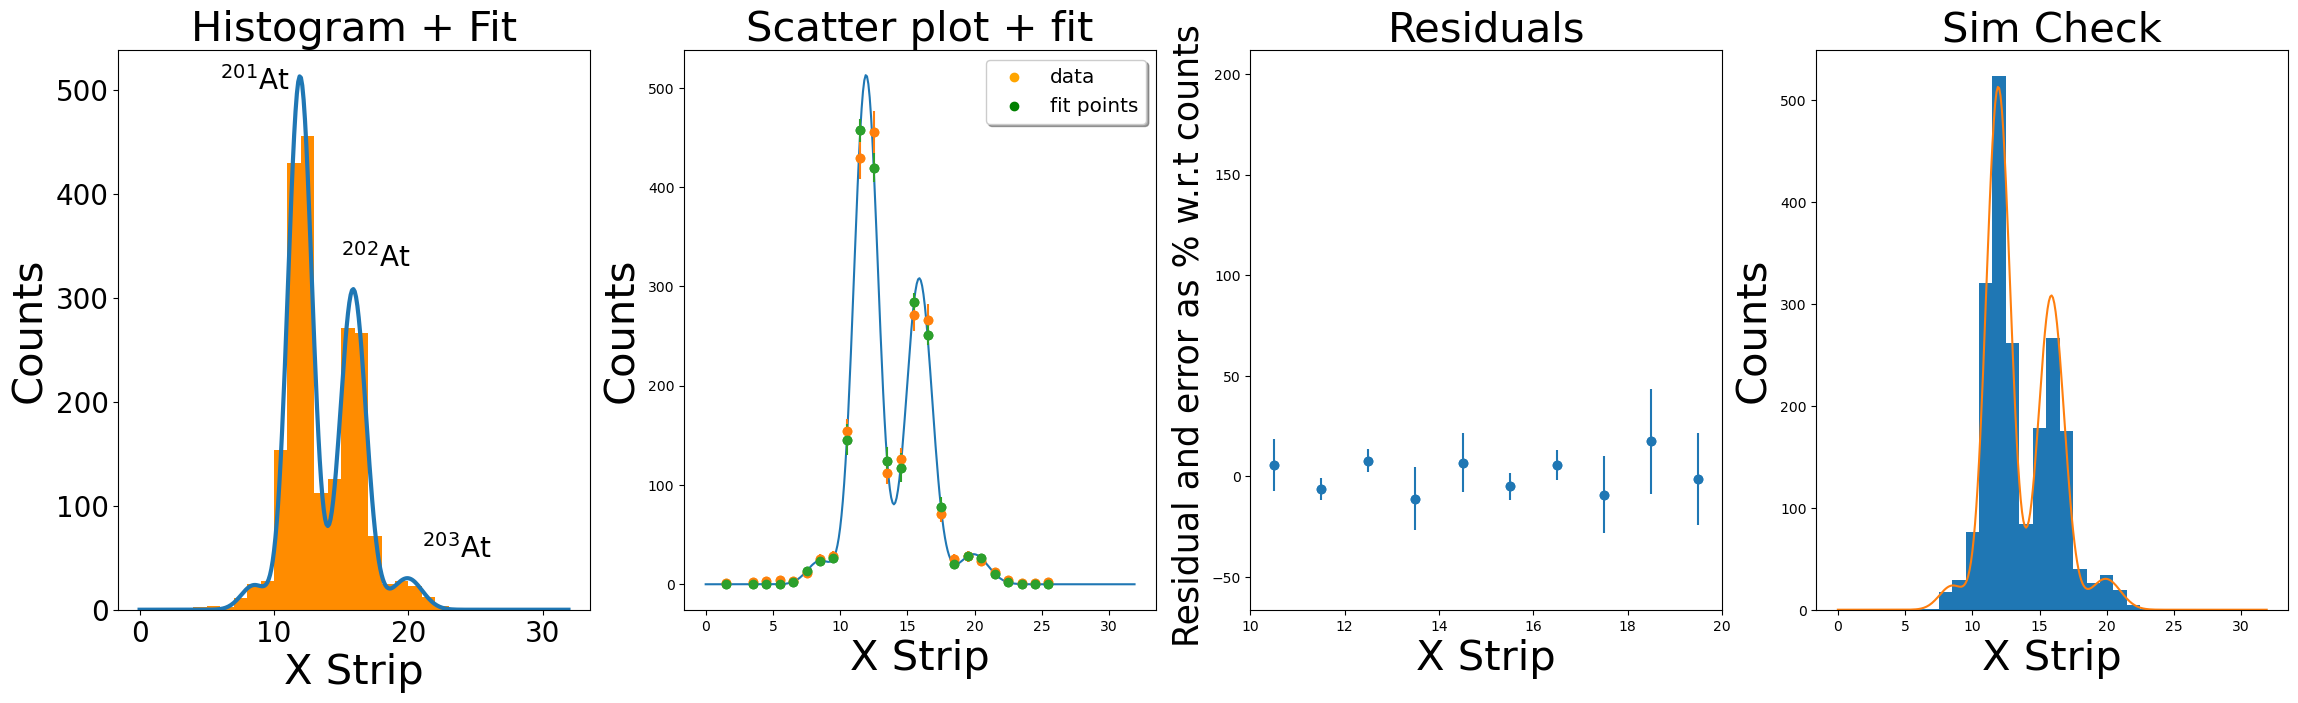

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.72 (chi2/ndof = 2.1)    │              Nfcn = 904              │
│ EDM = 7.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [13]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

df, t1 = readDS('run231_037_output.txt', cal)

### Checking Energies
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,1)
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")
plt.title("Energies", fontsize = 30)

#### Finding Gates
plt.subplot(2,4,2)
plt.hist(df['y'], bins = 31)
plt.xlabel('Y Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Y Strip Gate", fontsize = 30)
plt.subplot(2,4,3)
plt.hist(df['xE'], bins = 200, range = (5000,6600))
plt.xlabel('X Strip Energy (KeV)', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("X Strip Energy Gate", fontsize = 30)


### Gating Data and setting up Histograms
gates = df[(df['y'] >=8) & (df['y'] < 17) & (df['xE'] > 5900) & (df['xE']<6500)]


### POXY
plt.subplot(2,4,4)
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x', fontsize = 30)
plt.ylabel('y', fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
hist= plt.hist(gates['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,8,1,435,11,1,310,16,1,30,20,1)
m.limits = [(0,None),(0,8.5),(.94,0.95),(0,None), (None,None), (None,None), (0,None ), (None,None), (None, None),(0,None),(None,None),(0, 1.1)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,5)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(6,500, "$^{201}$At", fontsize = 20)
plt.text(15,330, "$^{202}$At", fontsize = 20)
plt.text(21,50, "$^{203}$At", fontsize = 20)
### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [fourpeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(2.1)*np.std(y_b, axis=0)


#### Scatter plot with fit
plt.subplot(2,4,6)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')

### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.subplot(2,4,8)

mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(newcounts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


hist_sim= plt.hist(x, bins = bins,align='mid')
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()

print (m.migrad())



# f040

File: run231_040_output.txt
3 2020-03-26 09:01:45
[' At calibration', ' A/q=202/1', ' no gas added']


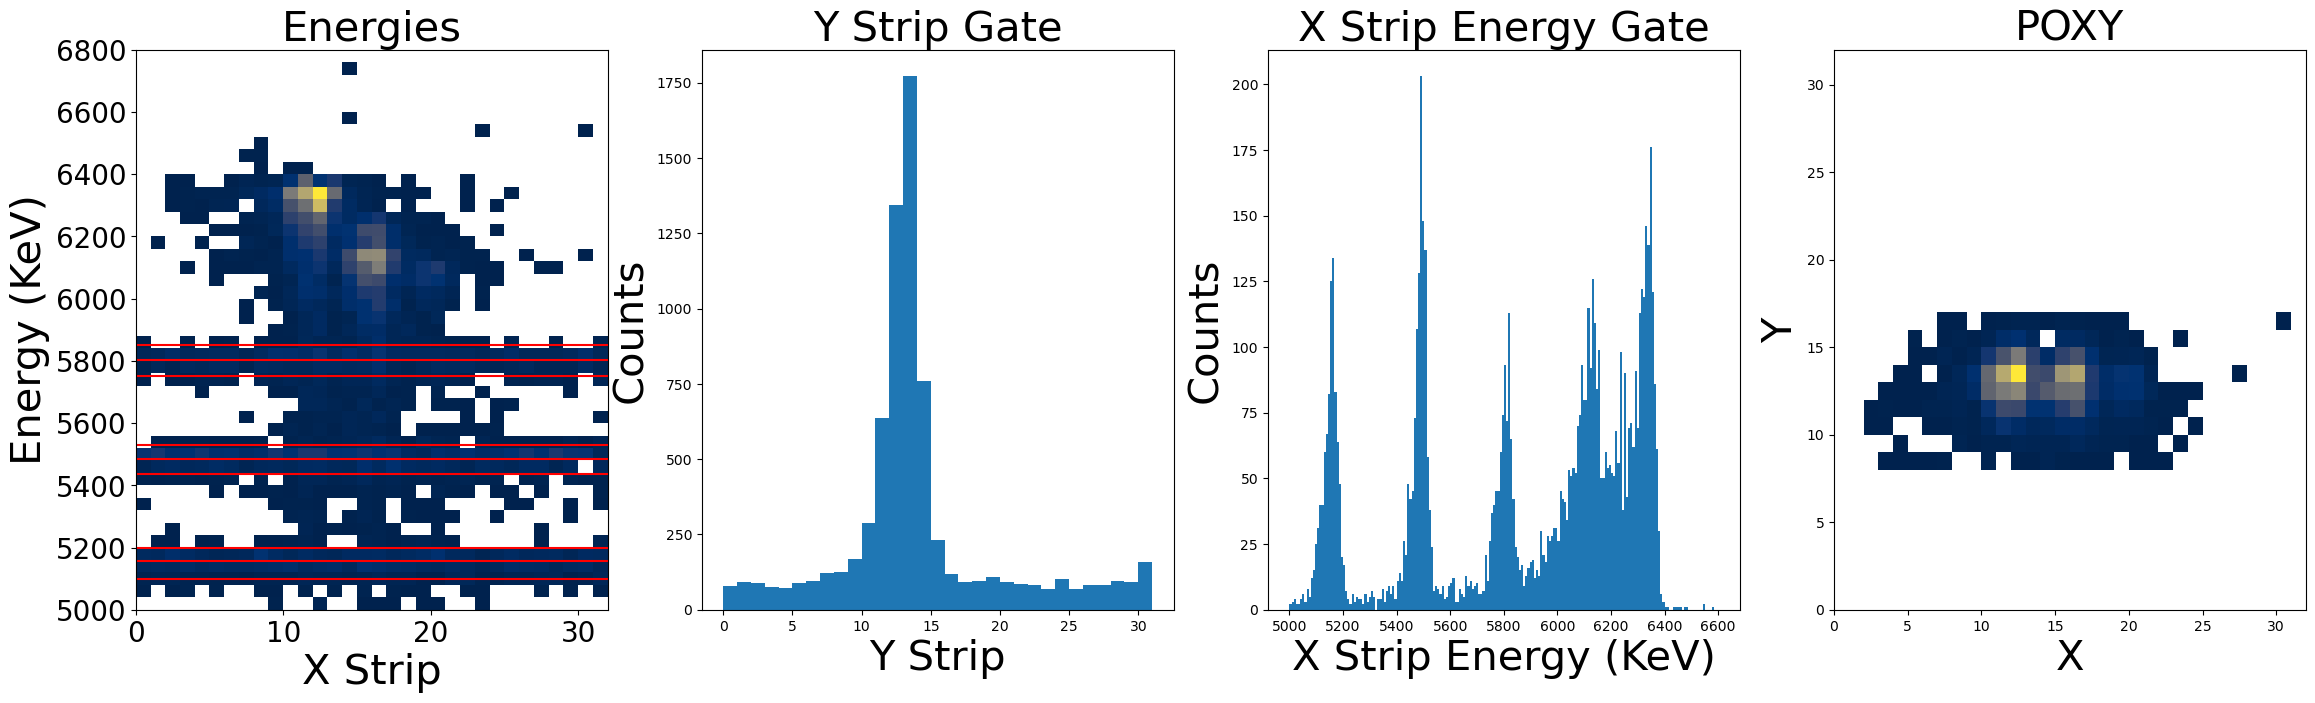

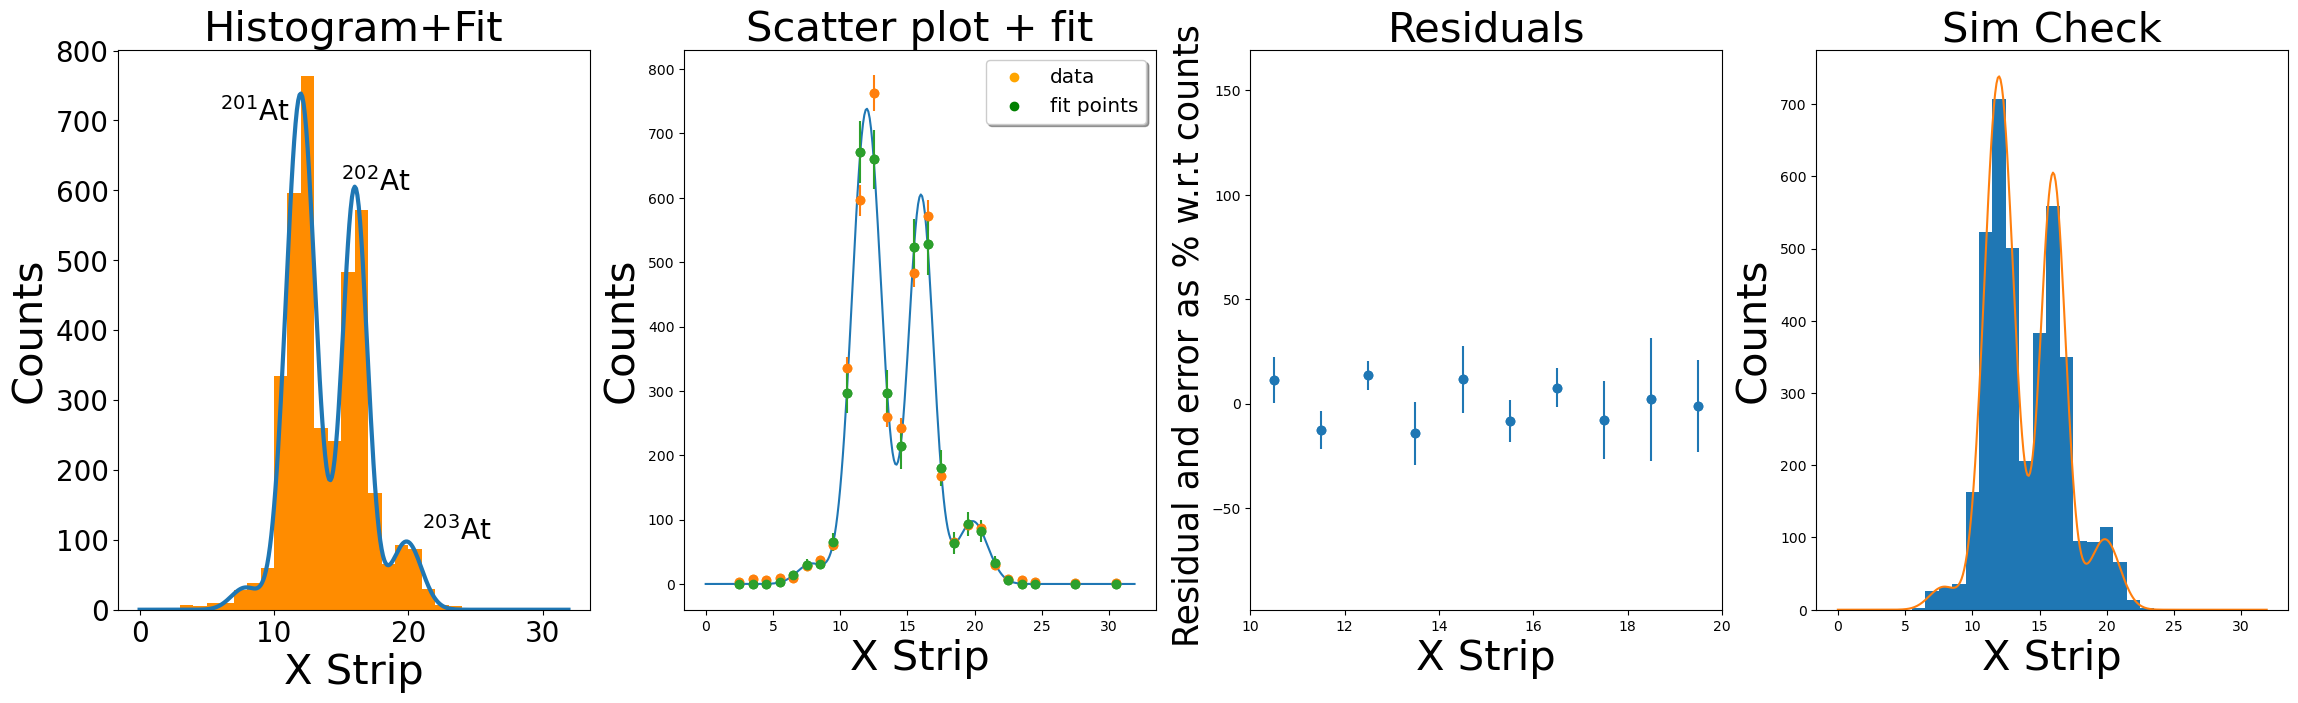

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 79.62 (chi2/ndof = 6.1)    │              Nfcn = 581              │
│ EDM = 9.59e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [14]:
cal = pd.read_csv('run231_calibration_run040.txt', sep = '\t', index_col = 0)

df_1, t1_1 = readDS('run231_040_output.txt', cal)

### Checking Energies
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,1)
plt.hist2d(df_1['x'], df_1['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")
plt.title("Energies", fontsize = 30)

#### Finding Gates
plt.subplot(2,4,2)
plt.hist(df_1['y'], bins = 31)
plt.xlabel('Y Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Y Strip Gate", fontsize = 30)
plt.subplot(2,4,3)
plt.hist(df_1['xE'], bins = 200, range = (5000,6600))
plt.xlabel('X Strip Energy (KeV)', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("X Strip Energy Gate", fontsize = 30)

### Gating Data and setting up Histograms
gates_1 = df_1[(df_1['y'] >=8) & (df_1['y'] < 17) & (df_1['xE'] > 5900) & (df_1['xE']<6500)]




### POXY
plt.subplot(2,4,4)
plt.hist2d(gates_1['x'], gates_1['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('X', fontsize = 30)
plt.ylabel('Y', fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_1['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,9,1,760,12.55,1.0915,610,16.57,.9339,100,20.411,1.042)
m.limits = [(0,None),(None,7.85),(0,1.04),(0,None), (None,None), (None,None), (0,None ), (0,None), (0, None),(0,None),(0,None),(0, None)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,5)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Histogram+Fit',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.text(6,700, "$^{201}$At", fontsize = 20)
plt.text(15,600, "$^{202}$At", fontsize = 20)
plt.text(21,100, "$^{203}$At", fontsize = 20)

### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [fourpeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(6.1)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)


#### Scatter plot with fit
plt.subplot(2,4,6)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize= 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel("X Strip", fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')

### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.subplot(2,4,8)

mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(newcounts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


hist_sim= plt.hist(x, bins = bins,align='mid')
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()

print(m.migrad())



# f044

File: run231_044_output.txt
1 2020-03-26 16:10:14
[' At calibration A/q=202/1']


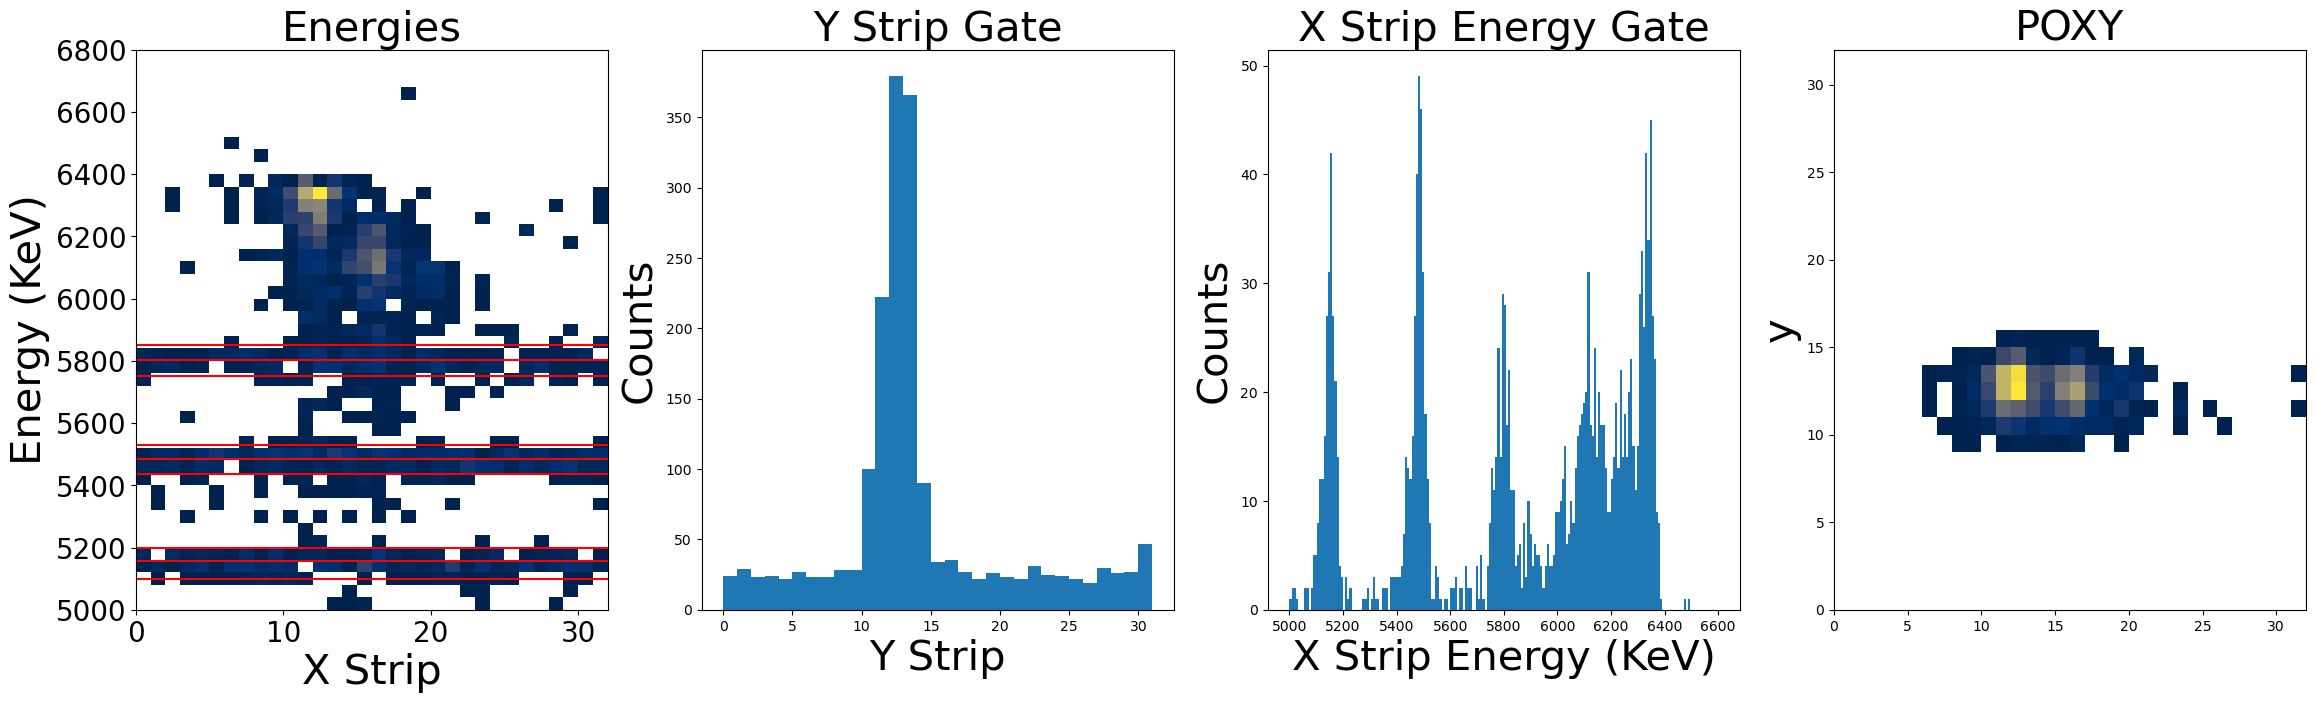

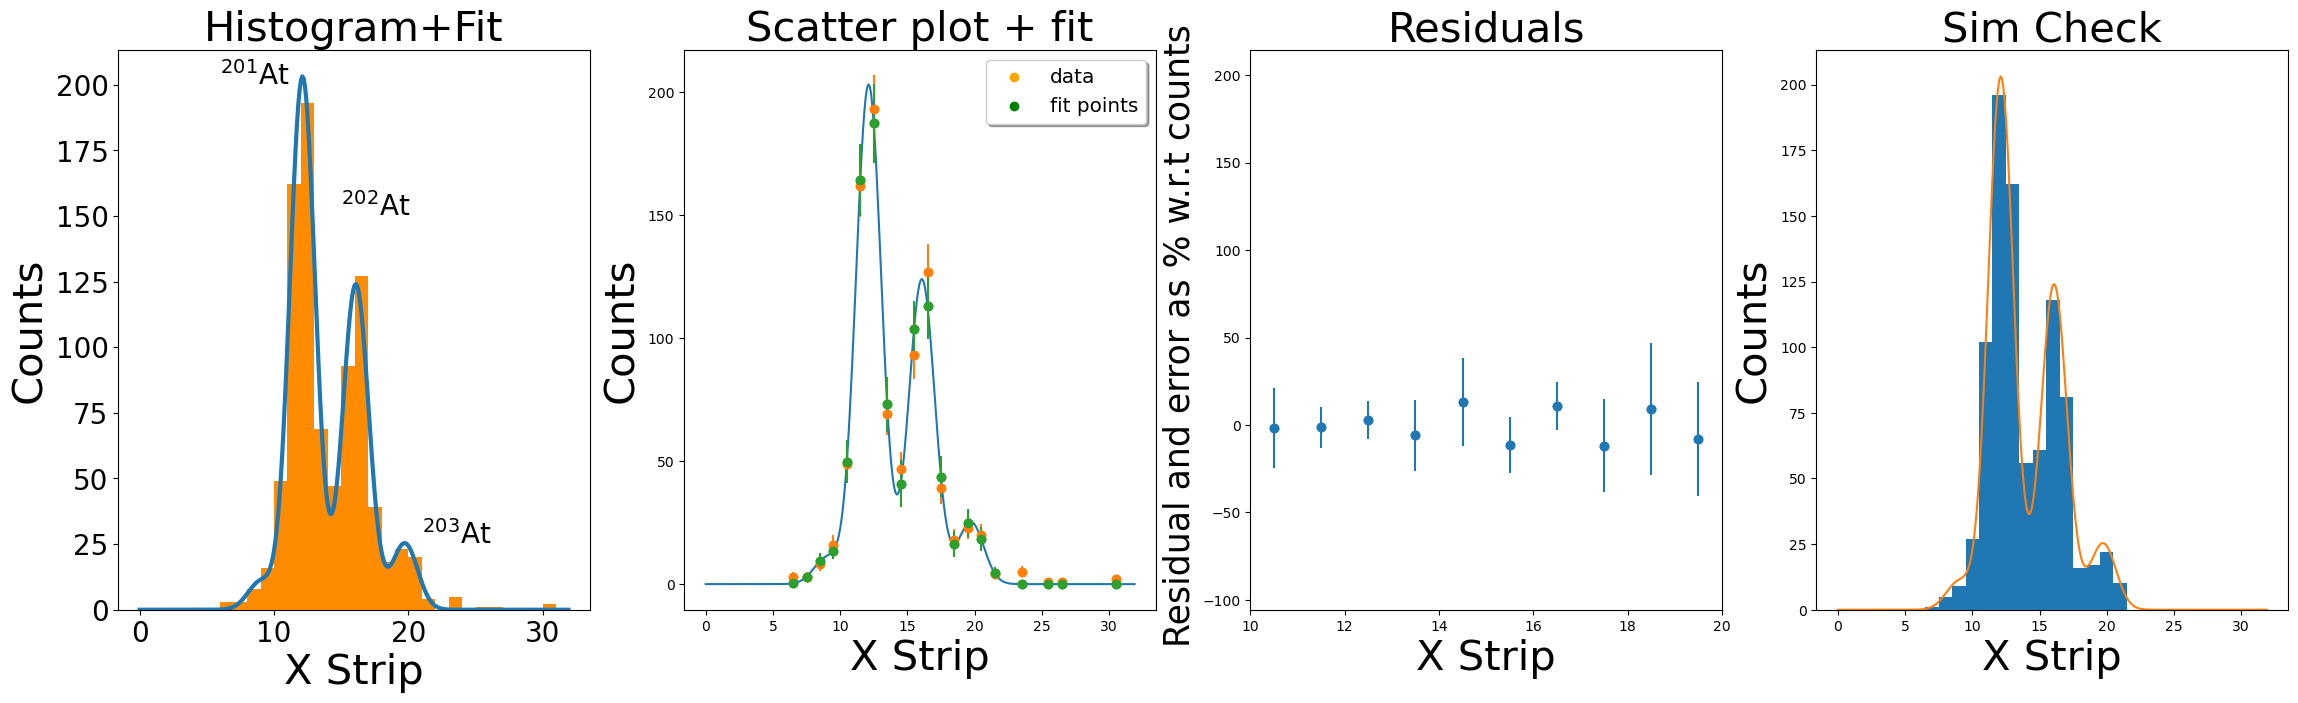

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.1 (chi2/ndof = 2.1)     │              Nfcn = 474              │
│ EDM = 1.35e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [15]:
cal = pd.read_csv('run231_calibration_run044.txt', sep = '\t', index_col = 0)

df_2, t1_2 = readDS('run231_044_output.txt', cal)

### Checking Energies
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,1)
plt.hist2d(df_2['x'], df_2['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

#### Finding Gates
plt.subplot(2,4,2)
plt.hist(df_2['y'], bins = 31)
plt.xlabel('Y Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Y Strip Gate", fontsize = 30)
plt.subplot(2,4,3)
plt.hist(df_2['xE'], bins = 200, range = (5000,6600))
plt.xlabel('X Strip Energy (KeV)', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("X Strip Energy Gate", fontsize = 30)

### Gating Data and setting up Histograms
gates_2 = df_2[(df_2['y'] >=9) & (df_2['y'] < 16) & (df_2['xE'] > 5900) & (df_2['xE']<6500)]


### POXY
plt.subplot(2,4,4)
plt.hist2d(gates_2['x'], gates_2['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.ylabel('x',fontsize = 30)
plt.ylabel('y',fontsize = 30)
plt.title('POXY',fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_2['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,14.2,9,1,207,12.642,.957,133,16.661,.919,26.3,20.27,.98)
m.limits = [(0,None),(None,9),(0.9,0.95),(0,None), (None,None), (None,None), (0,None ), (None,None), (None, None),(0,None),(None,None),(0, None)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,5)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Histogram+Fit',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.text(6,200, "$^{201}$At", fontsize = 20)
plt.text(15,150, "$^{202}$At", fontsize = 20)
plt.text(21,25, "$^{203}$At", fontsize = 20)

### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [fourpeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(2.1)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)


#### Scatter plot with fit
plt.subplot(2,4,6)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize= 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.ylabel('Counts',fontsize = 30)

### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)


### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total




mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(newcounts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


plt.subplot(2,4,8)
hist_sim= plt.hist(x, bins = bins,align='mid')
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()

plt.show()


print (m.migrad())


# f055

File: run231_055_output.txt
4 2020-03-27 02:49:04
[' scale mpod to 202/1+ ', ' change bgs magnets to At settings', ' do fiona calibration', ' start at 5:07am']


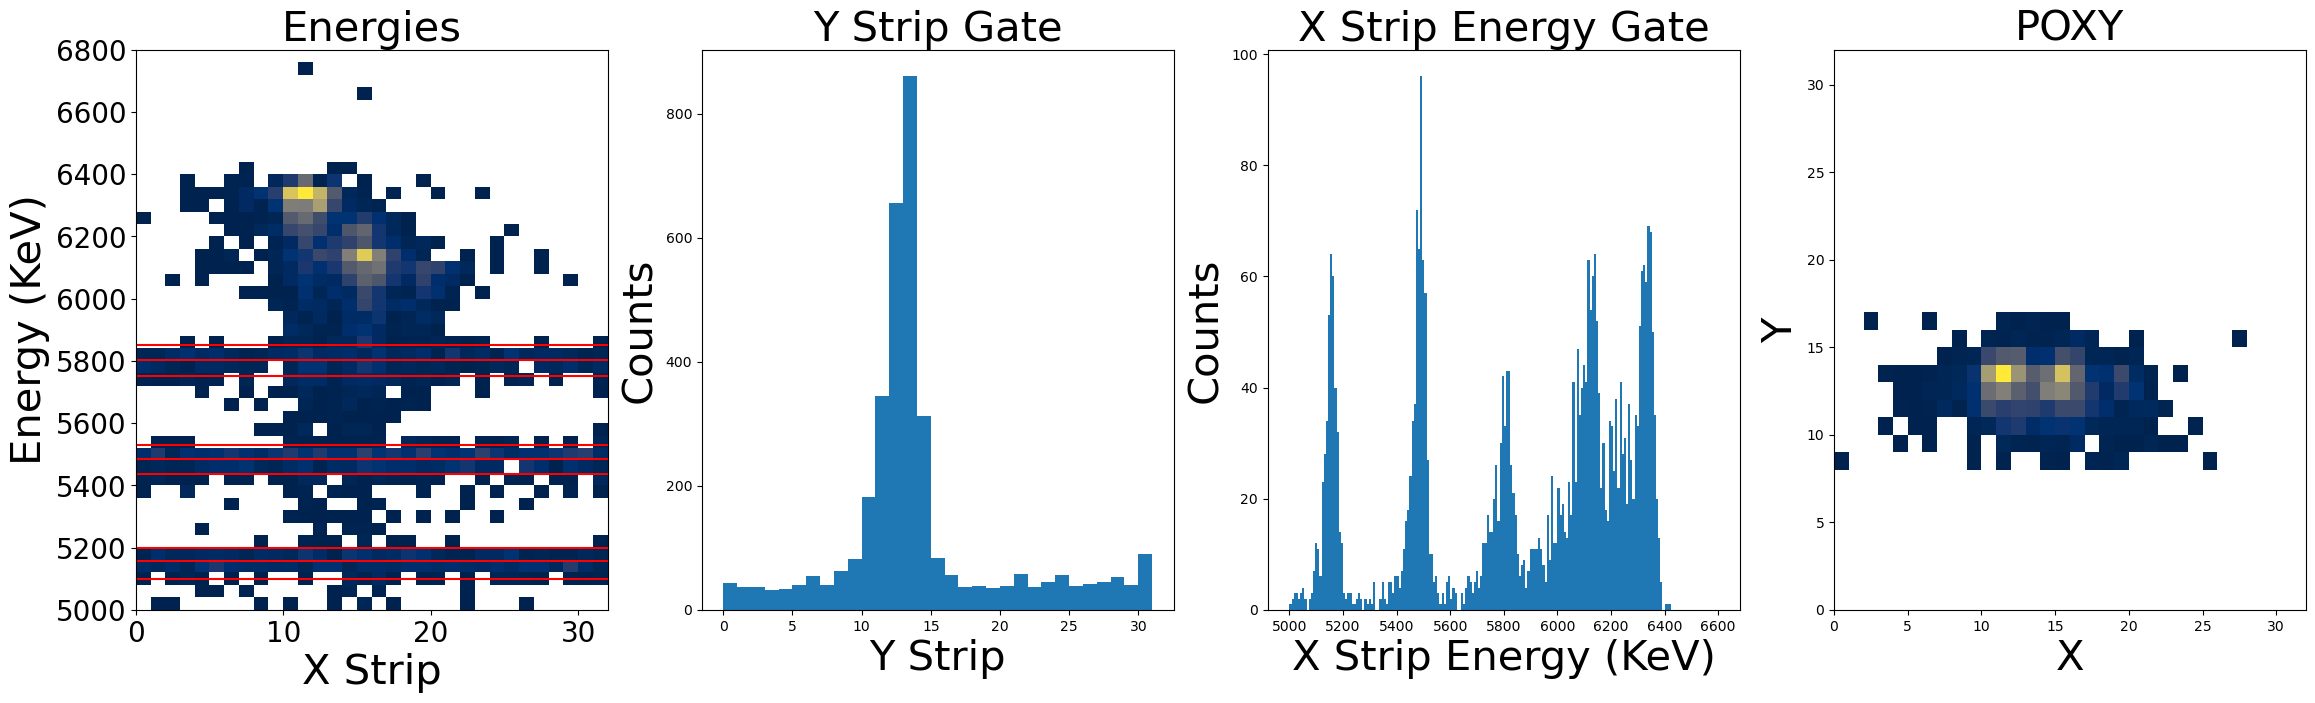

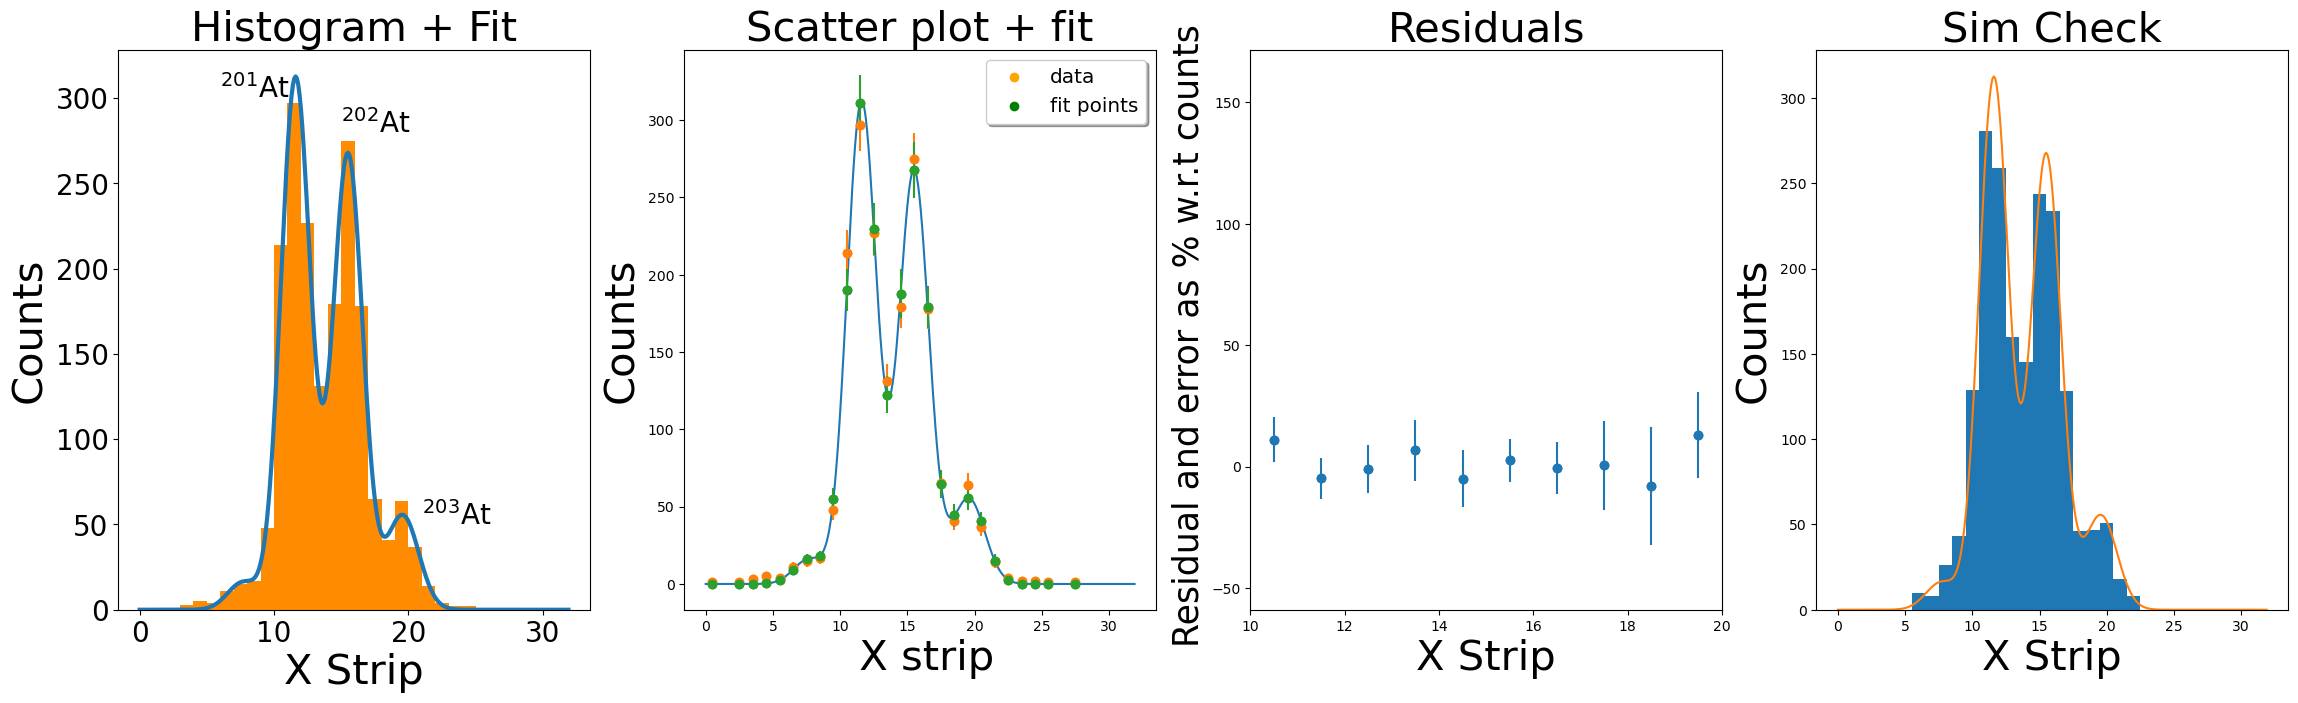

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.57 (chi2/ndof = 1.7)    │              Nfcn = 631              │
│ EDM = 2.89e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [16]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df_3, t1_3 = readDS('run231_055_output.txt', cal)

### Checking Energies
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,1)
plt.hist2d(df_3['x'], df_3['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

#### Finding Gates
plt.subplot(2,4,2)
plt.hist(df_3['y'], bins = 31)
plt.xlabel('Y Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Y Strip Gate", fontsize = 30)
plt.subplot(2,4,3)
plt.hist(df_3['xE'], bins = 200, range = (5000,6600))
plt.xlabel('X Strip Energy (KeV)', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("X Strip Energy Gate", fontsize = 30)

### Gating Data and setting up Histograms
gates_3 = df_3[(df_3['y'] >=8) & (df_3['y'] < 17) & (df_3['xE'] > 5900) & (df_3['xE']<6500)]


### POXY
plt.subplot(2,4,4)
plt.hist2d(gates_3['x'], gates_3['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('X',fontsize = 30)
plt.ylabel('Y',fontsize = 30)
plt.title('POXY',fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_3['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,13.5,8,1,308,12.063,1.17,269,16.043,1.106,63,20.087,1.106)
m.limits = [(0,None),(7.69,7.7),(1,1.14),(0,None), (None,None), (None,None), (0,None), (None,None), (None, None),(0,None),(None,None),(None,None)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,5)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Histogram + Fit',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.text(6,300, "$^{201}$At", fontsize = 20)
plt.text(15,280, "$^{202}$At", fontsize = 20)
plt.text(21,50, "$^{203}$At", fontsize = 20)


### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [fourpeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(1.7)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)




#### Scatter plot with fit
plt.subplot(2,4,6)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel(" X strip", fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')

### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.subplot(2,4,8)

mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(newcounts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


hist_sim= plt.hist(x, bins = bins,align='mid')
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()


print (m.migrad())



# f075

File: run231_075_output.txt
3 2020-03-28 02:47:04
[' mpod = 202/1+', ' do a fiona calibration with At', ' still have butane in the trap']


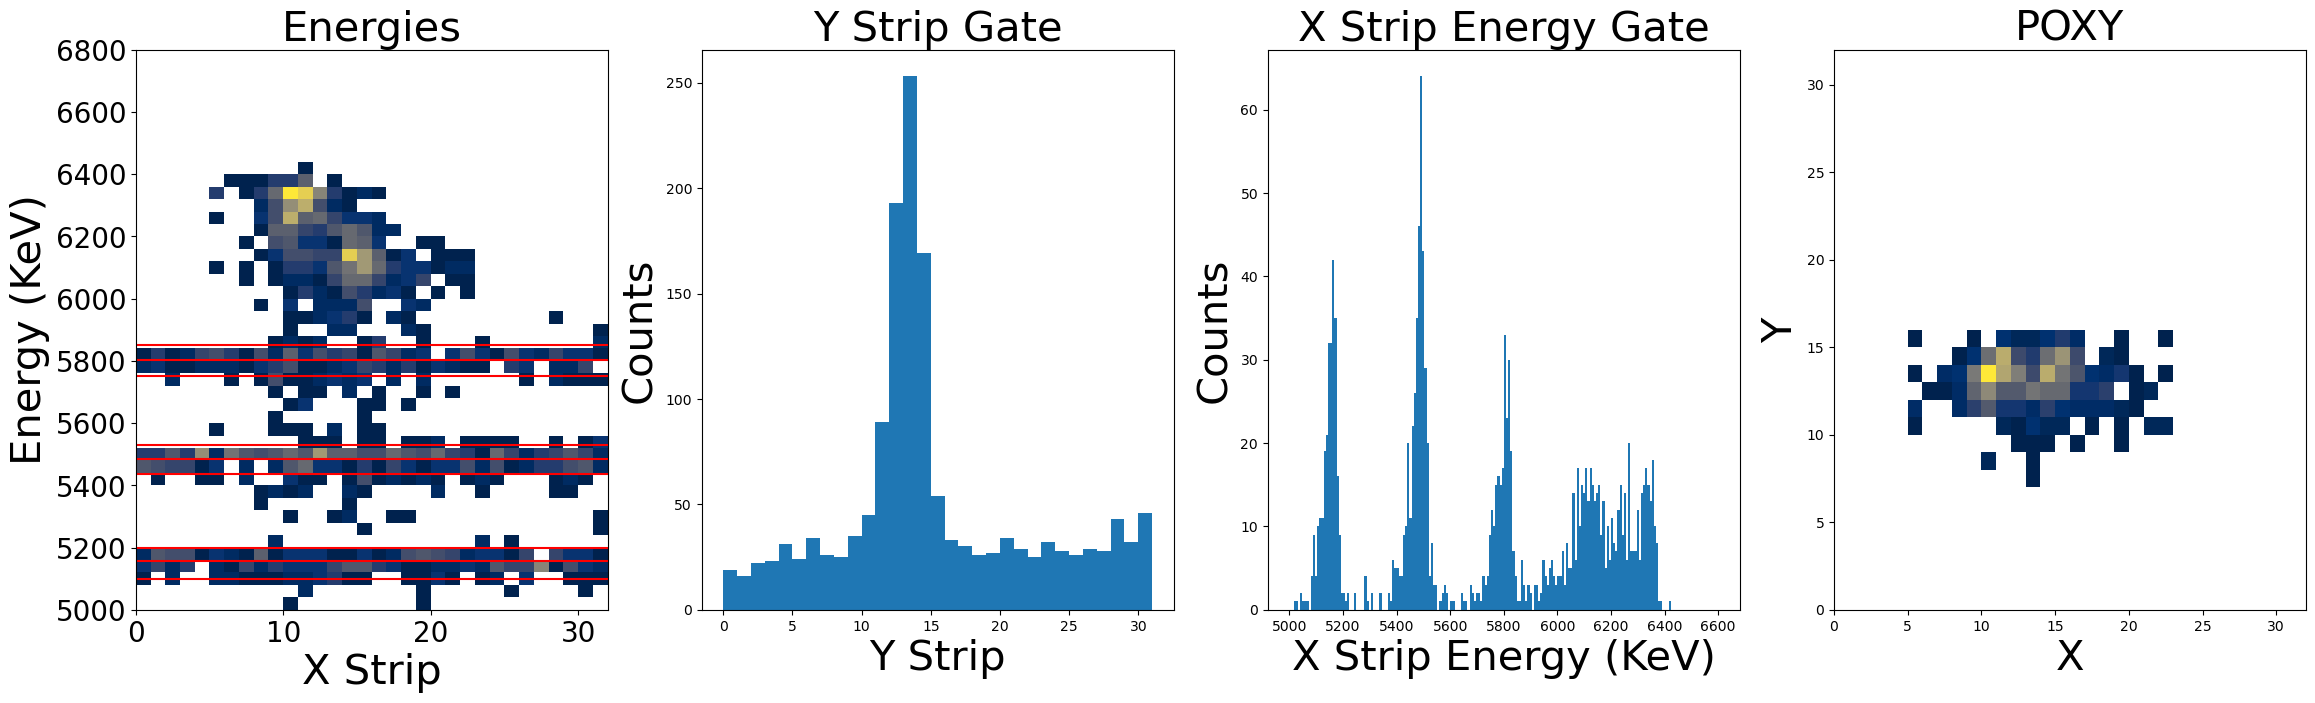

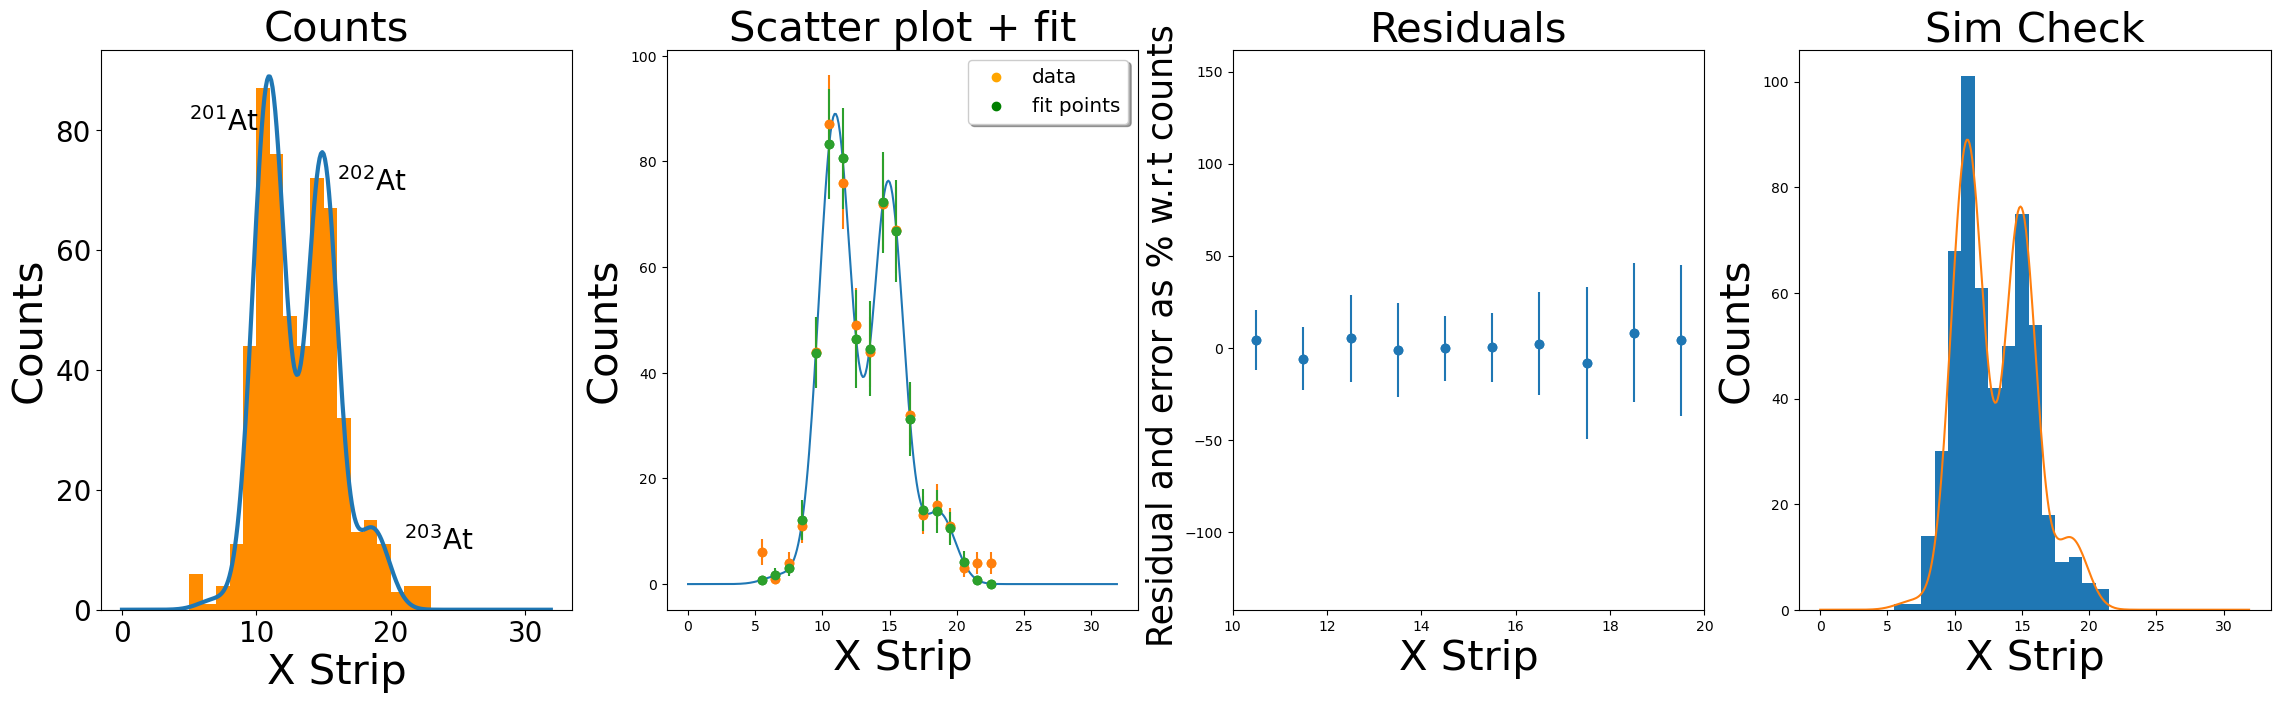

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.9 (chi2/ndof = 2.2)     │              Nfcn = 749              │
│ EDM = 4.95e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [17]:
cal = pd.read_csv('run231_calibration_run075.txt', sep = '\t', index_col = 0)

df_4, t1_4 = readDS('run231_075_output.txt', cal)

### Checking Energies
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,1)
plt.hist2d(df_4['x'], df_4['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

#### Finding Gates
plt.subplot(2,4,2)
plt.hist(df_4['y'], bins = 31)
plt.xlabel('Y Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Y Strip Gate", fontsize = 30)
plt.subplot(2,4,3)
plt.hist(df_4['xE'], bins = 200, range = (5000,6600))
plt.xlabel('X Strip Energy (KeV)', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("X Strip Energy Gate", fontsize = 30)


### Gating Data and setting up Histograms
gates_4 = df_4[(df_4['y'] >=7) & (df_4['y'] < 16) & (df_4['xE'] > 5900) & (df_4['xE']<6500)]


### POXY
plt.subplot(2,4,4)
plt.hist2d(gates_4['x'], gates_4['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.title('POXY', fontsize = 30)
plt.xlabel('X', fontsize = 30)
plt.ylabel('Y', fontsize = 30)
plt.show()

### Creating the histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_4['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,2.3,8,1.2,88,11.419,1.201,77,15.394,1.13,14,19.19,1.32)
m.limits = [(0,None),(6.9,6.97),(0,1.18),(0,None), (0,None), (None,None), (0,None), (0,None), (None, None),(0,None),(0,None),(0, 1.2)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,5)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.text(5,80, "$^{201}$At", fontsize = 20)
plt.text(16,70, "$^{202}$At", fontsize = 20)
plt.text(21,10, "$^{203}$At", fontsize = 20)


### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [fourpeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(2.2)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)



#### Scatter plot with fit
plt.subplot(2,4,6)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel("X Strip", fontsize = 30)

### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.subplot(2,4,8)

mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(newcounts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


hist_sim= plt.hist(x, bins = bins,align='mid')
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()


print (m.migrad())



# f082

File: run231_082_output.txt
2 2020-03-28 12:10:17
[' calibration with At+', ' scaled to 202/1']


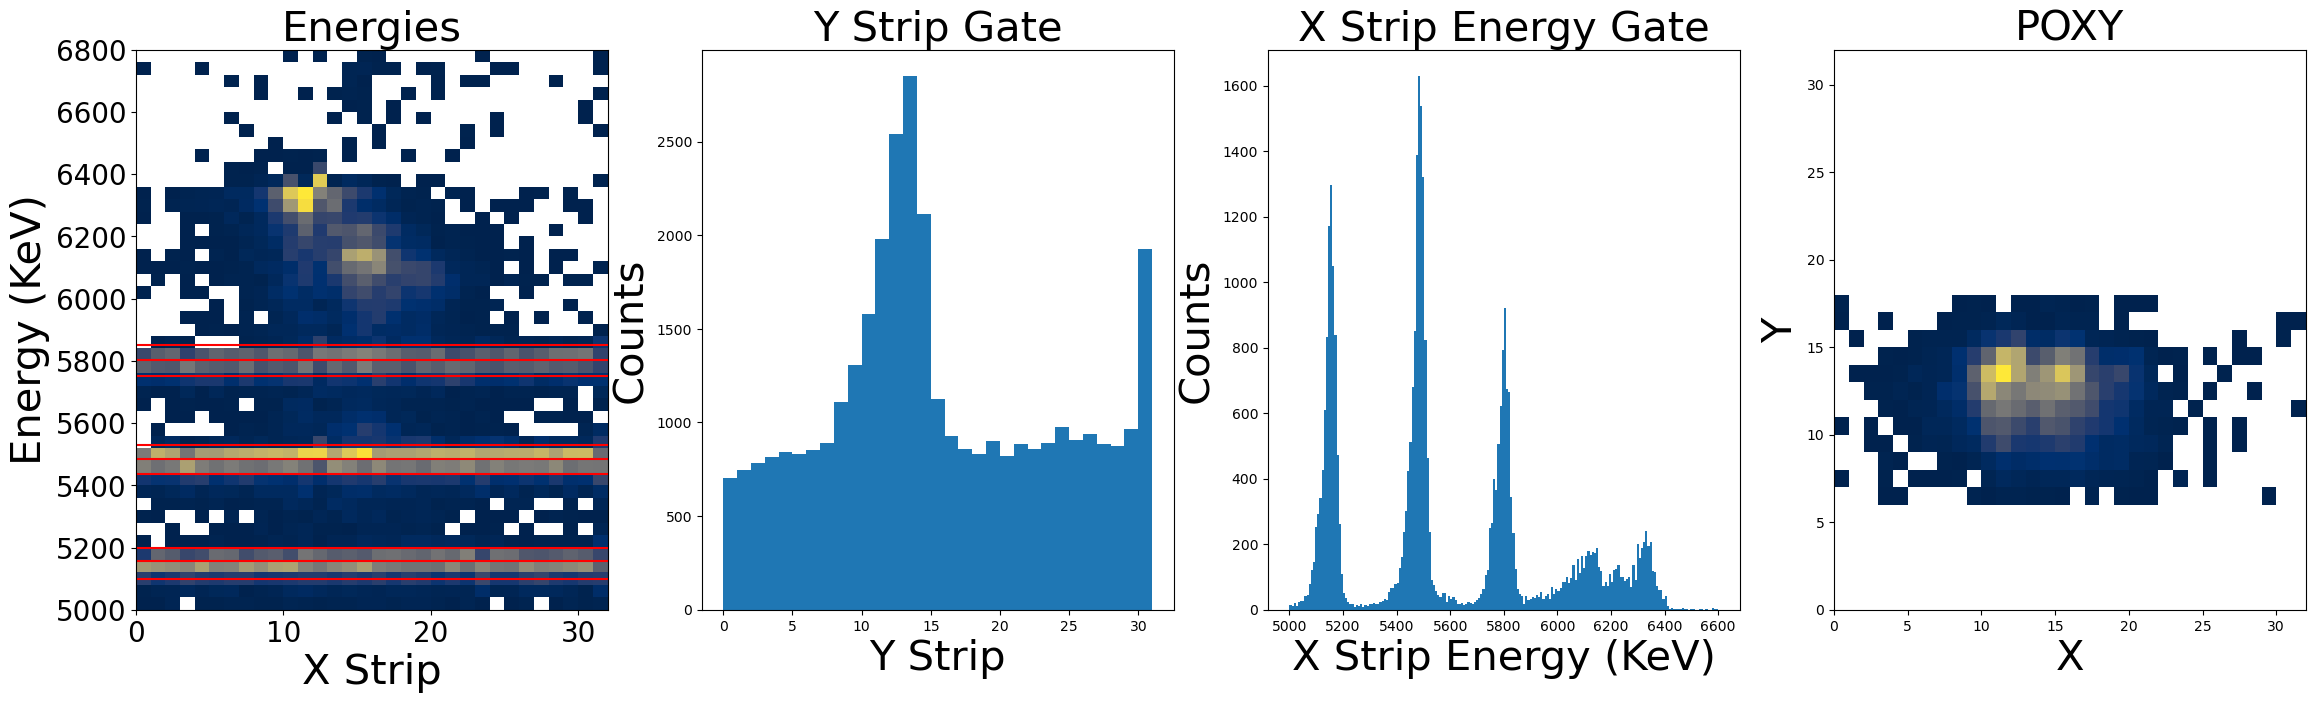

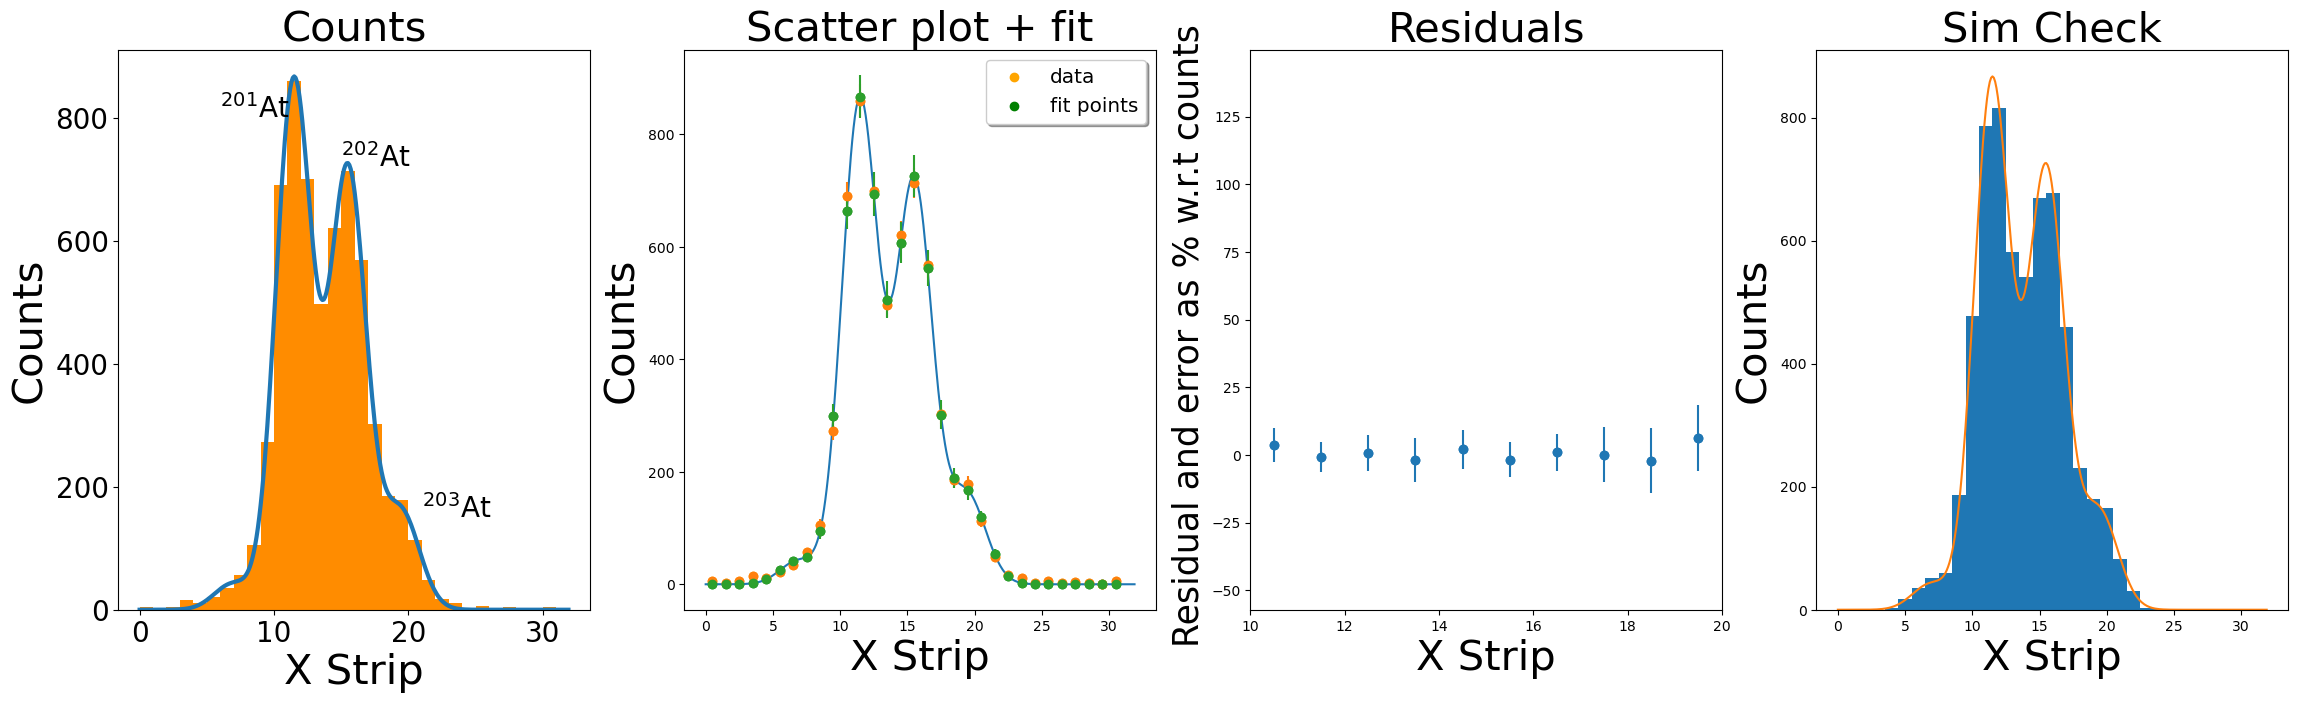

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 62.22 (chi2/ndof = 3.3)    │              Nfcn = 736              │
│ EDM = 7.89e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

In [18]:
from jacobi import propagate
cal = pd.read_csv('run231_calibration_run082.txt', sep = '\t', index_col = 0)

df_5, t1_5 = readDS('run231_082_output.txt', cal)

### Checking Energies
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,1)
plt.hist2d(df_5['x'], df_5['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Energy (KeV)',fontsize = 30)
plt.title('Energies',fontsize = 30)
plt.ylim(5000,6800)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")

#### Finding Gates
plt.subplot(2,4,2)
plt.hist(df_5['y'], bins = 31)
plt.xlabel('Y Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Y Strip Gate", fontsize = 30)
plt.subplot(2,4,3)
plt.hist(df_5['xE'], bins = 200, range = (5000,6600))
plt.xlabel('X Strip Energy (KeV)', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("X Strip Energy Gate", fontsize = 30)

### Gating Data and setting up Histograms
gates_5 = df_5[(df_5['y'] >=6) & (df_5['y'] < 18) & (df_5['xE'] > 5900) & (df_5['xE']<6500)]


### POXY
plt.subplot(2,4,4)
plt.hist2d(gates_5['x'], gates_5['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('X', fontsize = 30)
plt.ylabel('Y', fontsize = 30)
plt.title('POXY', fontsize = 30)
plt.show()


### Creating the histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_5['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,110,8.5,1.4,832,11.8948,1.331,790,15.9122,1.527,177,20.145,1.256)
m.limits = [(0,None),(0,6.9),(1,1.36),(0,None), (0,None), (None,None), (0,None), (0,None), (None,None),(0,None),(0,None),(0,1.4)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]
yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
plt.figure(figsize = (28,16))
plt.axes().set_aspect('equal')
plt.subplot(2,4,5)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)
plt.text(6,800, "$^{201}$At", fontsize = 20)
plt.text(15,720, "$^{202}$At", fontsize = 20)
plt.text(21,150, "$^{203}$At", fontsize = 20)


### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [fourpeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(3.3)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)


#### Scatter plot with fit
plt.subplot(2,4,6)
plt.plot(bins_,yy)

plt.title("Scatter plot + fit", fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')
plt.ylabel("Counts", fontsize = 30)
plt.xlabel("X Strip", fontsize = 30)
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')





### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)


### Fit Check/ Sim
area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4

area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total


plt.subplot(2,4,8)


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = sum(newcounts)
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


hist_sim= plt.hist(x, bins = bins,align='mid')
plt.plot(bins_,yy)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.title("Sim Check", fontsize = 30)
plt.show()


print (m.migrad())

print (bins)
print (hist)

